In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

from moviepy.editor import ImageSequenceClip
import tqdm

from src.model import Net
from src.utils import load_emoji, pad_img, process_img, init_grid, damage_masks, SamplePool
from src.config import CHANNEL_N, POOL_SIZE, BATCH_SIZE, DAMAGE, N_DAMAGE

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
n_episodes = 8000
# Init model
model = Net(device).to(device)
# Zero out parameters parameters of the final conv layer to zero
nn.init.zeros_(model.conv2.weight)
nn.init.zeros_(model.conv2.bias)

seed = init_grid(device)

pool = SamplePool(seed.repeat_interleave(POOL_SIZE, 0))

target_img = load_emoji('🦎')
target_img = pad_img(target_img)
target_img = torch.tensor(target_img.T[None, ...]).to(device)
target_img.requires_grad_ = True

lr = 2e-3
lr_gamma = 0.1

def loss_func(output, target):
    # returns a loss for each batch element
    return torch.mean(torch.square(output[:,:4,...] - target_img), dim=(1,2,3))

optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-08)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor = lr_gamma, patience = 1000, min_lr = 1e05)

running_loss = deque(maxlen = 100)

def train_step(x):
    n_steps = np.random.randint(64, 97)
    for s in range(n_steps):
        x = model(x)

    optimizer.zero_grad()
    loss = torch.mean(loss_func(x, target_img))
    loss.backward()
    for p in model.parameters():
        p.grad = p.grad * (torch.norm(p.grad)+1e-8)
    optimizer.step()
    return x, loss


pbar = tqdm.tqdm(range(n_episodes), mininterval=1.)

# Training happens here
for e in pbar:
    x = pool.sample()
    # sort x by descending losses
    losses = loss_func(x, target_img)
    x = x[losses.argsort(descending=True)]
    # replace the highest-loss sample with the seed state
    x[0] = seed.clone()
    if DAMAGE:
        x[-N_DAMAGE:] = x[-N_DAMAGE:] * damage_masks(N_DAMAGE, device)
    
    x, loss = train_step(x)
    lr_scheduler.step(loss)
    
    pool.x[:BATCH_SIZE] = x.detach().clone()
    running_loss.append(loss.detach().item())
    pbar.set_description(f'Epoch {e+1}, avg loss: {"NA" if len(running_loss)==0 else np.mean(running_loss):.2e}')

In [3]:
torch.save(model.state_dict(), 'trained_model/lizard.zip')
#model = Net(device).to(device)
#model_dict = torch.load('trained_model/lizard.zip', map_location=torch.device('cpu'))
#model.load_state_dict(model_dict)

In [4]:
frames = []

x = init_grid(device)
with torch.no_grad():
    for i in range(100):
        x = model(x)
        #if i%10 == 9:
        frames.append(process_img(x))

clip = ImageSequenceClip(frames, fps=10)
clip.write_gif('growth.gif')
#clip.ipython_display()

MoviePy - Building file growth.gif with imageio.


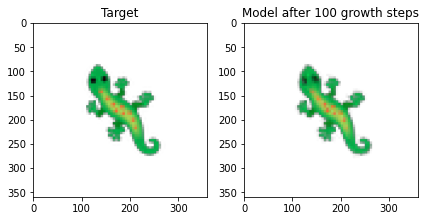

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(process_img(target_img))
ax1.set_title('Target')

ax2.imshow(frames[-1])
ax2.set_title('Model after 100 growth steps')
plt.tight_layout()
plt.savefig('target_vs_model.png', facecolor = 'white')
plt.show()